# Fighting Fire with Data - Starter Notebook

This notebook should help you get started with the 'Fighting Fire with Data' hackathon on Zindi. In it we cover:
- Loading the data
- Simple EDA and an example of feature enginnering
- Suggestions for validation split
- Creating a simple model
- Making a submission
- Some tips for improving your score


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import shap
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline

C:\Users\Anarchy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# The training data.
var_defs = pd.read_csv('variable_definitions.csv')
var_defs

,Variable,Description
0,ID,The IDs take the form of [area ID]_yyyy-mm-dd....
1,area,Area ID
2,date,The date that the data is aggregated over
3,lat,Latitude of the center of the area
4,lon,Longitude of the center of the area
5,burn_area,Percentage of the area burnt
6,climate_aet,"Actual evapotranspiration, derived using a one..."
7,climate_def,"Climate water deficit, derived using a one-dim..."
8,climate_pdsi,Palmer Drought Severity Index
9,climate_pet,Reference evapotranspiration (ASCE Penman-Mont...


In [3]:
# The training data.
pd.set_option('display.max_columns', None)
train = pd.read_csv('Train.csv')
train.head()

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2001-01-01,-15.858835,29.237029,0.0,1195,0,263,1195,206,10,1692,1861,0,211,317,2493,111,141,413.474762,0.0,0.0,0.018654,0.0,0.714446,0.012174,0.244890,0.009836,0.0,0.256932
1,1_2001-01-01,-15.858835,29.487029,0.0,1196,0,232,1196,201,10,1859,1867,0,211,318,2497,112,138,429.034543,0.0,0.0,0.000000,0.0,0.654783,0.000095,0.345121,0.000000,0.0,0.273093
2,2_2001-01-01,-15.858835,29.737029,0.0,1190,0,314,1190,192,10,1677,1861,0,208,317,2486,109,141,477.246432,0.0,0.0,0.000000,0.0,0.516421,0.000000,0.483579,0.000000,0.0,0.285109
3,3_2001-01-01,-15.858835,29.987029,0.0,1144,0,321,1144,186,66,1061,1864,0,196,303,2333,98,124,646.388681,0.0,0.0,0.000000,0.0,0.299000,0.163902,0.537098,0.000000,0.0,0.298418
4,4_2001-01-01,-15.858835,30.237029,0.0,1187,0,413,1187,186,9,1714,1852,0,204,314,2426,109,145,582.340637,0.0,0.0,0.000000,0.0,0.277392,0.067742,0.654866,0.000000,0.0,0.315621


In [4]:
# The test set - notice there is no 'burn_area' column.
test = pd.read_csv('Test.csv')
test.head(1)

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,1974,0,217,303,2481,99,148,413.474762,0.0,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243


# EDA + Feature Engineering

In [5]:
# Look at distribution of each variable
train.describe(include="all")

,ID,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
count,83148,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.0,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,8.314800e+04,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000
unique,83148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0_2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-19.014557,29.860856,0.007632,484.491124,828.892721,-30.806237,1313.382992,54.576322,6.215134,305.477919,2281.967901,0.0,140.830303,285.288654,1554.532123,127.380117,208.414574,978.992612,0.006158,0.000017,0.008583,4.066313e-08,0.160628,0.037453,0.785382,0.000354,0.001424,0.078551
std,NaN,1.588444,1.751090,0.029226,470.467480,546.934469,235.802930,315.209838,71.997561,21.480399,400.956123,333.049616,0.0,44.631924,34.840502,458.461471,44.172381,47.550163,297.497348,0.053111,0.000141,0.059046,3.535121e-06,0.192957,0.106050,0.233953,0.001773,0.014233,0.104464
min,NaN,-22.358835,25.487029,0.000000,0.000000,0.000000,-563.000000,587.000000,0.000000,0.000000,1.000000,1167.000000,0.0,19.000000,139.000000,704.000000,32.000000,48.000000,265.379418,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000
25%,NaN,-20.358835,28.487029,0.000000,50.000000,375.000000,-212.000000,1081.000000,1.000000,0.000000,70.000000,2028.000000,0.0,103.000000,262.000000,1139.000000,97.000000,174.000000,768.375959,0.000000,0.000000,0.000000,0.000000e+00,0.014993,0.000000,0.655322,0.000000,0.000000,0.002017
50%,NaN,-18.858835,29.987029,0.000000,302.000000,858.000000,-108.000000,1290.000000,22.000000,1.000000,149.000000,2272.000000,0.0,150.000000,287.000000,1544.000000,118.000000,205.000000,1022.813217,0.000000,0.000000,0.000000,0.000000e+00,0.076706,0.000139,0.880600,0.000000,0.000000,0.028503
75%,NaN,-17.858835,31.237029,0.000000,931.000000,1211.000000,142.000000,1517.000000,87.000000,4.000000,329.000000,2545.000000,0.0,177.000000,310.000000,1942.000000,149.000000,241.000000,1197.977194,0.000000,0.000000,0.000000,0.000000e+00,0.246498,0.015166,0.971209,0.000000,0.000000,0.125500


In [6]:
# Display basic information about the training data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83148 entries, 0 to 83147
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             83148 non-null  object 
 1   lat            83148 non-null  float64
 2   lon            83148 non-null  float64
 3   burn_area      83148 non-null  float64
 4   climate_aet    83148 non-null  int64  
 5   climate_def    83148 non-null  int64  
 6   climate_pdsi   83148 non-null  int64  
 7   climate_pet    83148 non-null  int64  
 8   climate_pr     83148 non-null  int64  
 9   climate_ro     83148 non-null  int64  
 10  climate_soil   83148 non-null  int64  
 11  climate_srad   83148 non-null  int64  
 12  climate_swe    83148 non-null  int64  
 13  climate_tmmn   83148 non-null  int64  
 14  climate_tmmx   83148 non-null  int64  
 15  climate_vap    83148 non-null  int64  
 16  climate_vpd    83148 non-null  int64  
 17  climate_vs     83148 non-null  int64  
 18  elevat

## Feature engineering

In [7]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

# Extract area_ID from ID
train['area_ID'] = train['ID'].apply(lambda x: int(x.split('_')[0]))
test['area_ID'] = test['ID'].apply(lambda x: int(x.split('_')[0]))

# Convert area_ID to categorical
train['area_ID'] = train['area_ID'].astype('category')
test['area_ID'] = test['area_ID'].astype('category')

# Apply one-hot encoding to area_ID
train = pd.get_dummies(train, columns=['area_ID'], prefix=['area_ID'])
test = pd.get_dummies(test, columns=['area_ID'], prefix=['area_ID'])

# Ensure train and test have the same columns
all_columns = set(train.columns).union(set(test.columns))
train = train.reindex(columns=all_columns, fill_value=0)
test = test.reindex(columns=all_columns, fill_value=0)

In [8]:
# Create combined climate variables
train['hot_and_dry'] = (train['climate_tmmx'] - train['climate_tmmn']) / (train['climate_pr'] + 1)
test['hot_and_dry'] = (test['climate_tmmx'] - test['climate_tmmn']) / (test['climate_pr'] + 1)

train['moisture_stress'] = train['climate_aet'] / (train['climate_pr'] + train['climate_soil'] + 1)
test['moisture_stress'] = test['climate_aet'] / (test['climate_pr'] + test['climate_soil'] + 1)

train['temperature_range'] = train['climate_tmmx'] - train['climate_tmmn']
test['temperature_range'] = test['climate_tmmx'] - test['climate_tmmn']

train['drought_index'] = train['climate_pdsi'] + train['climate_def']
test['drought_index'] = test['climate_pdsi'] + test['climate_def']

train['vpd_temp_ratio'] = train['climate_vpd'] / (train['climate_tmmx'] + 1)
test['vpd_temp_ratio'] = test['climate_vpd'] / (test['climate_tmmx'] + 1)

train['temp_precip_interaction'] = (train['climate_tmmx'] - train['climate_tmmn']) * train['climate_pr']
test['temp_precip_interaction'] = (test['climate_tmmx'] - test['climate_tmmn']) * test['climate_pr']

train['vpd_moisture_interaction'] = train['vpd_temp_ratio'] * train['moisture_stress']
test['vpd_moisture_interaction'] = test['vpd_temp_ratio'] * test['moisture_stress']

# Geographic Regions
# Define latitude and longitude zones based on the specific ranges
train['lat_zone'] = pd.cut(train['lat'], bins=[-26, -22, -18, -16], labels=['Southernmost', 'Mid-Southern', 'Northernmost'])
test['lat_zone'] = pd.cut(test['lat'], bins=[-26, -22, -18, -16], labels=['Southernmost', 'Mid-Southern', 'Northernmost'])

train['lon_zone'] = pd.cut(train['lon'], bins=[26, 29, 31, 33], labels=['Westernmost', 'Mid-Western', 'Easternmost'])
test['lon_zone'] = pd.cut(test['lon'], bins=[26, 29, 31, 33], labels=['Westernmost', 'Mid-Western', 'Easternmost'])

# One-hot encoding geographic regions
train = pd.get_dummies(train, columns=['lat_zone', 'lon_zone'], drop_first=True)
test = pd.get_dummies(test, columns=['lat_zone', 'lon_zone'], drop_first=True)

# Combine climate temperature range with land cover types
for i in range(9):
    train[f'temp_range_landcover_{i}'] = train['temperature_range'] * train[f'landcover_{i}']
    test[f'temp_range_landcover_{i}'] = test['temperature_range'] * test[f'landcover_{i}']

# Combine precipitation with land cover types
for i in range(9):
    train[f'precipitation_landcover_{i}'] = train['precipitation'] * train[f'landcover_{i}']
    test[f'precipitation_landcover_{i}'] = test['precipitation'] * test[f'landcover_{i}']

# Variables to lag
lag_vars = ['climate_pr', 'climate_tmmx', 'climate_tmmn', 'climate_soil', 'climate_aet', 'drought_index']

# Create lagged variables
for var in lag_vars:
    for lag in [3, 6, 9, 12]:
        train[f'{var}_lag_{lag}'] = train[var].shift(lag)
        test[f'{var}_lag_{lag}'] = test[var].shift(lag)

# Dropping NaNs that result from lagging
train = train.dropna().reset_index(drop=True)
test = test.dropna().reset_index(drop=True)


## Data Split

In [9]:
# Use the last 3 years of the dataset for validation
train_all = train.copy().dropna()
train = train_all.loc[train_all.date < '2011-01-01']
valid = train_all.loc[train_all.date >= '2011-01-01']
print(train.shape, valid.shape)

# Define input and output columns
drop_cols = ['ID', 'date', 'burn_area', 'month', 'year', 'landcover_0', 'landcover_1', 'landcover_3', 'landcover_7', 'landcover_8', 'climate_swe', 'climate_ro']
in_cols = [col for col in train.columns if col not in drop_cols]
target_col = 'burn_area'

X_train = train[in_cols]
y_train = train[target_col]
X_valid = valid[in_cols]
y_valid = valid[target_col]


(63948, 618) (19188, 618)


## Random Forest

In [10]:
# Create and fit the RandomForest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)  # Adjust n_estimators for better performance
rf_model.fit(X_train, y_train)
# Make predictions with RandomForest model
rf_preds = rf_model.predict(X_valid)

# Score the RandomForest model
rf_rmse = mean_squared_error(y_valid, rf_preds)**0.5
print('RandomForest RMSE:', rf_rmse)


RandomForest RMSE: 0.023053054221265527


RandomForest RMSE: 0.023056696864372485

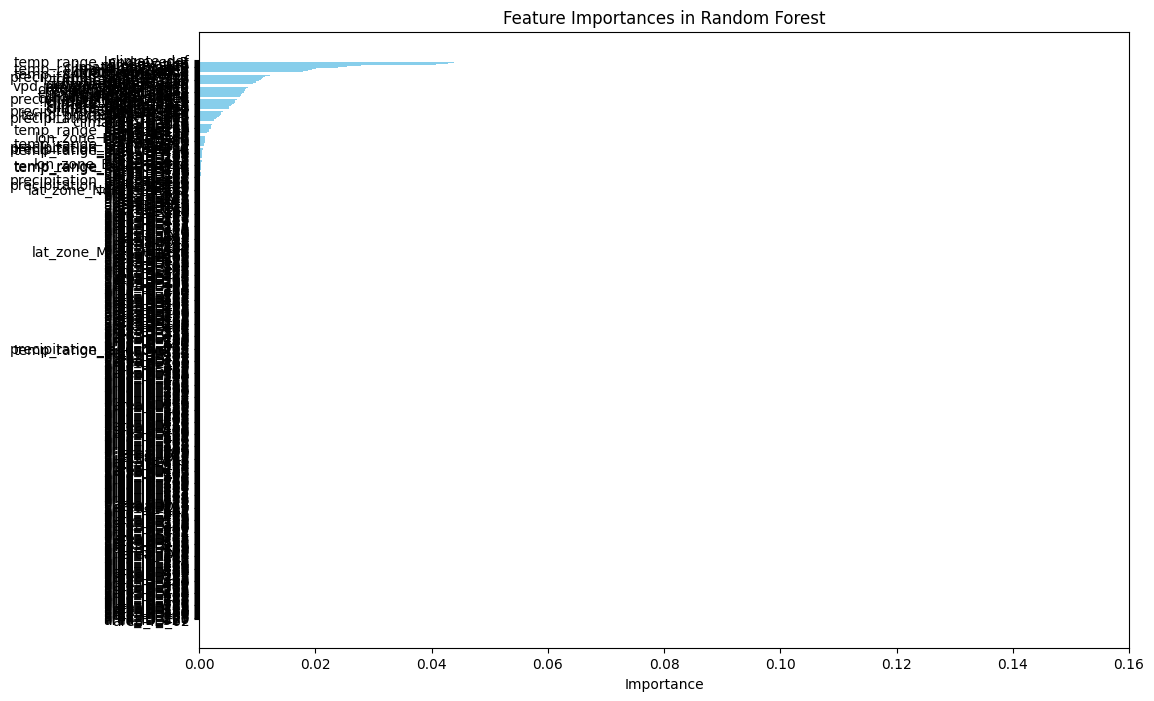

                       Feature    Importance
25                 climate_def  1.524132e-01
569     temp_range_landcover_5  7.198502e-02
477                        lat  5.342852e-02
36                   elevation  4.380317e-02
182               climate_srad  4.281408e-02
410                climate_vap  4.077550e-02
596         climate_soil_lag_9  2.791639e-02
30                 landcover_5  2.545889e-02
570     temp_range_landcover_6  2.381791e-02
556              drought_index  2.011091e-02
557             vpd_temp_ratio  1.939063e-02
584           climate_pr_lag_9  1.873988e-02
594         climate_soil_lag_3  1.787001e-02
487              precipitation  1.465609e-02
568     temp_range_landcover_4  1.261887e-02
123                 climate_vs  1.256008e-02
199                        lon  1.251675e-02
579  precipitation_landcover_6  1.223624e-02
3                  area_ID_118  1.129385e-02
601         climate_aet_lag_12  1.101538e-02
599          climate_aet_lag_6  1.083656e-02
71        

In [11]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': in_cols,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest')
plt.gca().invert_yaxis()
plt.show()

print(importance_df)

## XGB

In [12]:
# Create and fit the XGBoost model
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
# Make predictions with XGBoost model
xgb_preds = xgb_model.predict(X_valid)

# Score the XGBoost model
xgb_rmse = mean_squared_error(y_valid, xgb_preds)**0.5
print('XGBoost RMSE:', xgb_rmse)


XGBoost RMSE: 0.02281336111378403


XGBoost RMSE: 0.02288530801501201

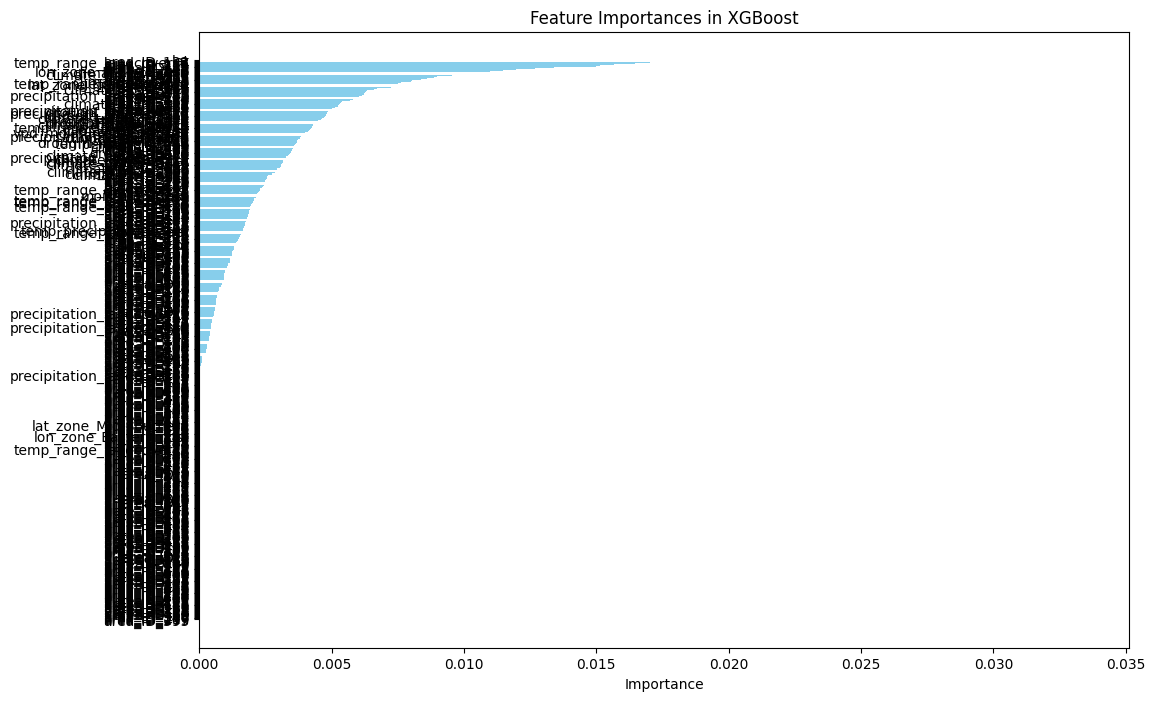

                       Feature  Importance
477                        lat    0.033458
116                area_ID_132    0.021537
569     temp_range_landcover_5    0.018210
33                 area_ID_184    0.017027
510                area_ID_215    0.016471
367                area_ID_153    0.015680
1                  area_ID_330    0.015130
372                 area_ID_15    0.014999
384                area_ID_247    0.013419
3                  area_ID_118    0.012667
191                area_ID_303    0.011984
562       lon_zone_Mid-Western    0.011464
481                area_ID_185    0.010998
584           climate_pr_lag_9    0.010940
199                        lon    0.009733
591         climate_tmmn_lag_6    0.009598
361                area_ID_133    0.009584
36                   elevation    0.009556
223                area_ID_213    0.008999
254                 area_ID_67    0.008874
158                area_ID_331    0.008592
111                area_ID_495    0.008396
583        

In [13]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for feature importances
xgb_importance_df = pd.DataFrame({
    'Feature': in_cols,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in XGBoost')
plt.gca().invert_yaxis()
plt.show()

print(xgb_importance_df)

In [14]:
# Feature Importance
feature_importances = xgb_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances for XGBRegressor:")
print(importance_df)

Feature Importances for XGBRegressor:
                       Feature  Importance
477                        lat    0.033458
116                area_ID_132    0.021537
569     temp_range_landcover_5    0.018210
33                 area_ID_184    0.017027
510                area_ID_215    0.016471
367                area_ID_153    0.015680
1                  area_ID_330    0.015130
372                 area_ID_15    0.014999
384                area_ID_247    0.013419
3                  area_ID_118    0.012667
191                area_ID_303    0.011984
562       lon_zone_Mid-Western    0.011464
481                area_ID_185    0.010998
584           climate_pr_lag_9    0.010940
199                        lon    0.009733
591         climate_tmmn_lag_6    0.009598
361                area_ID_133    0.009584
36                   elevation    0.009556
223                area_ID_213    0.008999
254                 area_ID_67    0.008874
158                area_ID_331    0.008592
111             

In [15]:
# Define categorical features for CatBoost
categorical_features = [col for col in X_train.columns if col.startswith('area_ID_') or col.startswith('lat_zone_') or col.startswith('lon_zone_')]

# Initialize CatBoost model
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    cat_features=categorical_features,
    random_state=42,
    verbose=100  # Print training progress every 100 iterations
)

# Fit the model
catboost_model.fit(X_train, y_train)

# Make predictions
catboost_preds = catboost_model.predict(X_valid)

# Score the CatBoost model
catboost_rmse = mean_squared_error(y_valid, catboost_preds, squared=False)
print('CatBoost RMSE:', catboost_rmse)


0:	learn: 0.0285272	total: 246ms	remaining: 4m 5s
100:	learn: 0.0183009	total: 11.9s	remaining: 1m 45s
200:	learn: 0.0158183	total: 36.4s	remaining: 2m 24s
300:	learn: 0.0142028	total: 51.1s	remaining: 1m 58s
400:	learn: 0.0129658	total: 1m 5s	remaining: 1m 37s
500:	learn: 0.0119180	total: 1m 20s	remaining: 1m 20s
600:	learn: 0.0110674	total: 1m 34s	remaining: 1m 2s
700:	learn: 0.0103301	total: 1m 48s	remaining: 46.4s
800:	learn: 0.0096688	total: 2m 3s	remaining: 30.8s
900:	learn: 0.0090923	total: 2m 17s	remaining: 15.1s
999:	learn: 0.0086004	total: 2m 31s	remaining: 0us
CatBoost RMSE: 0.02201365451260599


CatBoost RMSE: 0.022419215187138495

In [16]:
# Feature importance for CatBoost
catboost_importances = pd.DataFrame({
    'Feature': in_cols,
    'Importance': catboost_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)
print(catboost_importances)

                       Feature  Importance
36                   elevation    5.468686
410                climate_vap    4.277120
477                        lat    4.093359
25                 climate_def    4.072313
182               climate_srad    3.432483
570     temp_range_landcover_6    2.696899
569     temp_range_landcover_5    2.695565
123                 climate_vs    2.652801
556              drought_index    2.619444
30                 landcover_5    2.407307
603        drought_index_lag_6    2.349755
555          temperature_range    2.328845
604        drought_index_lag_9    2.306030
568     temp_range_landcover_4    2.124660
579  precipitation_landcover_6    2.100518
601         climate_aet_lag_12    1.999976
71                climate_pdsi    1.994450
599          climate_aet_lag_6    1.984269
602        drought_index_lag_3    1.923469
199                        lon    1.783444
587         climate_tmmx_lag_6    1.781109
557             vpd_temp_ratio    1.759611
594        

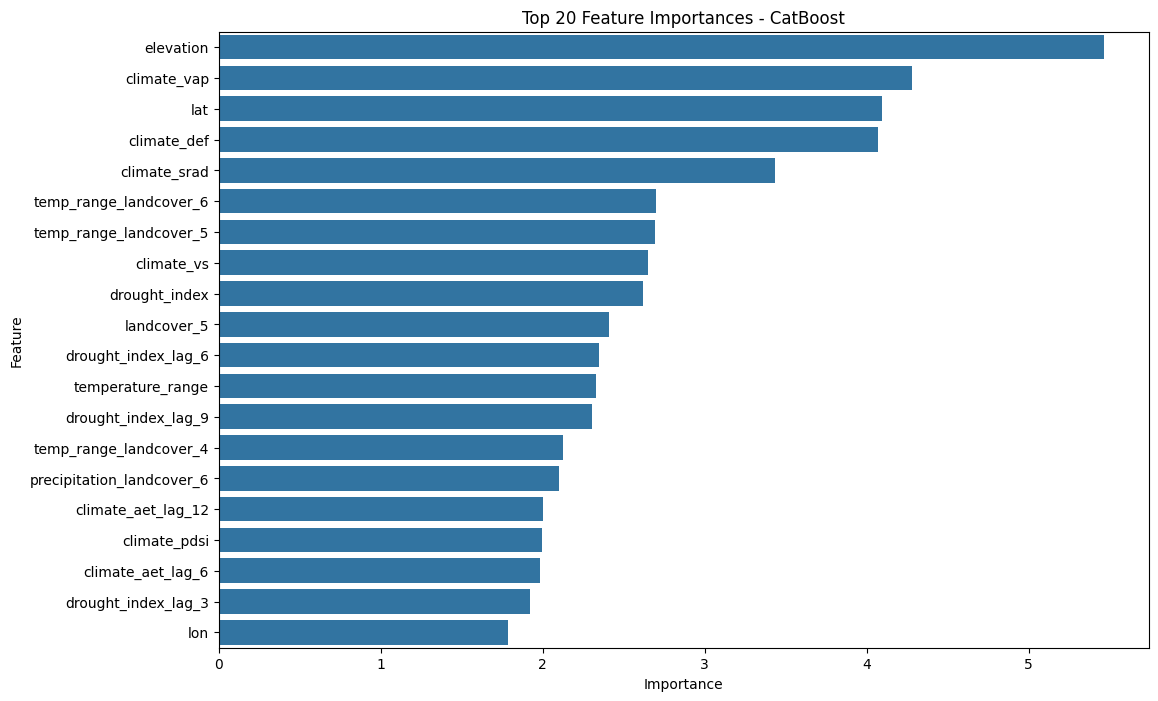

In [17]:
# Plotting feature importance for CatBoost
plt.figure(figsize=(12, 8))
sns.barplot(data=catboost_importances.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances - CatBoost')
plt.show()